<a href="https://colab.research.google.com/github/Luicazen/NLPTweets/blob/NN/NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow
%pip install --upgrade tensorflow
%pip install keras
%pip install keras-nlp
%pip install keras-hub
%pip install --upgrade keras keras-nlp keras-hub
%pip install pandas
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install transformers
%pip install --upgrade transformers
%pip install tensorflow
%pip install keras-nlp
%pip install scikit-learn
%pip install nltk
%pip install matplotlib-venn

In [2]:
import os
import sys
import importlib
import tensorflow as tf
from tensorflow import *
import keras
import keras_nlp
from keras import *
from keras.models import *
from keras_nlp import *
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import pandas as pd
import numpy as np
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, log_loss, classification_report
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

c:\Users\sarah\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarah\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


##Initial Visualization

In [3]:
# Load the train.csv file into a DataFrame
trainDF = pd.read_csv('train.csv')
# Display the first 5 rows of the DataFrame
display(trainDF.head())
# Display basic information about the DataFrame
trainDF.info()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# Load the train.csv file into a DataFrame
testDF = pd.read_csv('test.csv')
# Display the first 5 rows of the DataFrame
display(testDF.head())
# Display basic information about the DataFrame
testDF.info()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


#Initial Preprocessing

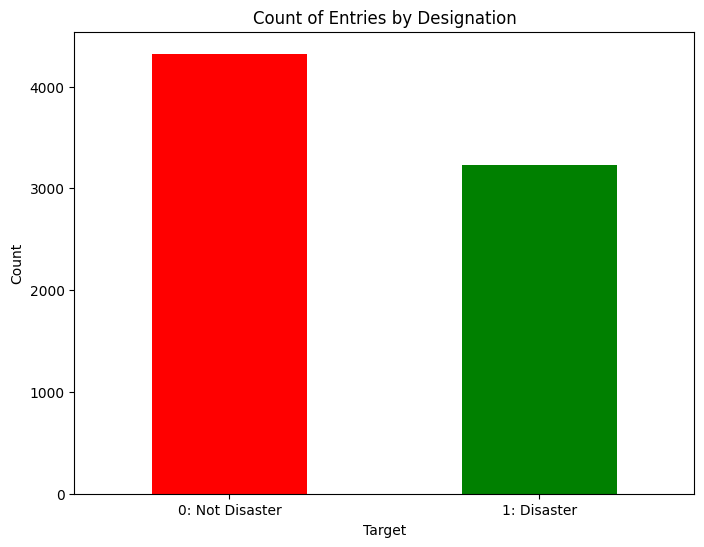

In [5]:
#Minor data preprocessing
#transform text to lowercase
trainDF["lowercase_text"] = trainDF["text"].str.lower()
#Filter out missing keywords
trainDF = trainDF[trainDF['keyword'].notnull()]#Graph the counts of target designations
targetCounts = trainDF['target'].value_counts()

plt.figure(figsize=(8,6))
targetCounts.plot(kind='bar', color=['red', 'green'])
plt.title('Count of Entries by Designation')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks([0, 1], ['0: Not Disaster', '1: Disaster'], rotation=0)

plt.show()

In [7]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_punctuation(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

def remove_numbers(text):
    return re.sub(r'[0-9]+', '', text)

def remove_empty_spaces(text):
    words = [word for word in text.split(" ") if (not word.strip() == "")]
    return " ".join(words)

def remove_stopwords(text):
    words = [word for word in text.split(" ") if word not in stop]
    return " ".join(words)
def clean_text(text):
  text = text.lower()
  text = remove_url(text)
  text = remove_html(text)
  text = remove_punctuation(text)
  text = remove_numbers(text)
  text = remove_empty_spaces(text)
  text = remove_stopwords(text)
  return text
example = trainDF["text"].iloc[0]
print("Before cleaning:", example)
print("After cleaning: ", clean_text(example))

Before cleaning: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
After cleaning:  bbcmtd wholesale markets ablaze


In [8]:
trainDF["cleaned_text"] = trainDF["text"].apply(clean_text)
testDF["cleaned_text"] = testDF["text"].apply(clean_text)

## Major Preprocessing

### Tokenization
Converting the 'text' and keyword columns into a numerical format suitable for a neural network using `tensorflow.keras.preprocessing.text.Tokenizer` to create word indices and `tensorflow.keras.preprocessing.sequence.pad_sequences` to ensure uniform length for the input sequences. Padding both columns to uniform length and storing.


**Reasoning**:
The subtask requires converting the 'text' column into a numerical format for a neural network. This involves importing `Tokenizer` and `pad_sequences`, initializing and fitting the tokenizer, converting text to sequences, padding them to a uniform length, and storing the word index.



In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# 4.a Tokenization and Padding of Text Data

#Set num_words to define the maximum number of words to keep (e.g., 10,000 common words)
numWords = 100000
#Set oov_tokenotherWords
otherWords = "<unk>"
#Initialize a Tokenizer object
tokenizer = Tokenizer(num_words=numWords, oov_token=otherWords)

#Fit the tokenizer on the 'text' column of df_train
tokenizer.fit_on_texts(trainDF['text'])

#Convert the 'text' column into sequences of integers
sequences = tokenizer.texts_to_sequences(trainDF['text'])

#Determine a suitable maximum sequence length (maxlen)
maxLen = max([len(x) for x in sequences])

# Pad these sequences to ensure they all have the same length
padded_sequences = pad_sequences(sequences, maxlen=maxLen, padding='post')

# 5. Store the word index mapping
word_index = tokenizer.word_index

print(f"Original text sample: {trainDF['text'].iloc[0]}")
print(f"Tokenized sequence sample: {sequences[0]}")
print(f"Padded sequence sample: {padded_sequences[0]}")
print(f"Vocabulary size: {len(word_index)}")

Original text sample: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Tokenized sequence sample: [6936, 2911, 1922, 637, 4, 2, 3, 6937]
Padded sequence sample: [6936 2911 1922  637    4    2    3 6937    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0]
Vocabulary size: 22883


In [10]:
from collections import Counter

# Track 100 most-used vocabulary tokens per target with no overlaps.

# Build index->word mapping from tokenizer
index_word = {idx: word for word, idx in tokenizer.word_index.items()}

# Count token occurrences per target
c0 = Counter()
c1 = Counter()

targets = trainDF['target'].tolist()

for seq, t in zip(sequences, targets):
    if not seq:
        continue
    if t == 0:
        c0.update(seq)
    else:
        c1.update(seq)

# Create DataFrame of token stats
rows = []
all_tokens = set(c0.keys()) | set(c1.keys())
for tok in all_tokens:
    rows.append((tok, index_word.get(tok, f"tok_{tok}"), c0.get(tok, 0), c1.get(tok, 0), c0.get(tok, 0) + c1.get(tok, 0)))
tokens_df = pd.DataFrame(rows, columns=["token_id", "word", "count_0", "count_1", "total"])

# Assign token to the target where it appears more; ties get no assignment initially
def pick_owner(r):
    if r.count_0 > r.count_1:
        return 0
    if r.count_1 > r.count_0:
        return 1
    return -1
tokens_df["owner"] = tokens_df.apply(pick_owner, axis=1)

# Collect top candidates per owner
top0 = tokens_df[tokens_df["owner"] == 0].sort_values("count_0", ascending=False)
top1 = tokens_df[tokens_df["owner"] == 1].sort_values("count_1", ascending=False)

# If not enough exclusive tokens, fill from remaining (ties or low-diff) while avoiding overlap
def build_top_list(primary_df, other_selected_words, target_col, n=100):
    selected = list(primary_df["word"].tolist())[:n]
    selected = [w for w in selected if w not in other_selected_words]
    if len(selected) >= n:
        return selected[:n]
    # fill from remaining tokens sorted by target_col descending, skipping already used words
    remaining = tokens_df[~tokens_df["word"].isin(selected) & ~tokens_df["word"].isin(other_selected_words)]
    remaining = remaining.sort_values(target_col, ascending=False)
    for w in remaining["word"].tolist():
        if len(selected) >= n:
            break
        if w not in selected and w not in other_selected_words:
            selected.append(w)
    return selected

# initial selections
sel0 = top0["word"].tolist()[:100]
sel1 = top1["word"].tolist()[:100]

# Ensure exclusivity by rebuilding with mutual awareness
final_sel0 = build_top_list(tokens_df[tokens_df["owner"]==0].sort_values("count_0", ascending=False), set(sel1), "count_0", 100)
final_sel1 = build_top_list(tokens_df[tokens_df["owner"]==1].sort_values("count_1", ascending=False), set(final_sel0), "count_1", 100)

# If still short for either, fill from remaining tokens by highest relative preference (count difference)
used = set(final_sel0) | set(final_sel1)
if len(final_sel0) < 100 or len(final_sel1) < 100:
    remaining = tokens_df[~tokens_df["word"].isin(used)].copy()
    remaining["diff_1_minus_0"] = remaining["count_1"] - remaining["count_0"]
    # fill target0 from highest negative diff, target1 from highest positive diff
    if len(final_sel0) < 100:
        cand0 = remaining.sort_values("diff_1_minus_0").loc[:, "word"].tolist()
        for w in cand0:
            if len(final_sel0) >= 100:
                break
            if w not in used:
                final_sel0.append(w); used.add(w)
    if len(final_sel1) < 100:
        cand1 = remaining.sort_values("diff_1_minus_0", ascending=False).loc[:, "word"].tolist()
        for w in cand1:
            if len(final_sel1) >= 100:
                break
            if w not in used:
                final_sel1.append(w); used.add(w)

# Final lists (guaranteed mutually exclusive)
top_tokens_target0 = final_sel0[:100]
top_tokens_target1 = final_sel1[:100]

print("Count target0 tokens:", len(top_tokens_target0))
print("Count target1 tokens:", len(top_tokens_target1))
print("Sample target0 tokens:", top_tokens_target0[:20])
print("Sample target1 tokens:", top_tokens_target1[:20])

# Optionally expose as DataFrame for inspection
exclusive_df = pd.DataFrame({
    "target0_top100": pd.Series(top_tokens_target0),
    "target1_top100": pd.Series(top_tokens_target1)
})

Count target0 tokens: 100
Count target1 tokens: 100
Sample target0 tokens: ['the',
 'a',
 'to',
 'i',
 'and',
 'you',
 'is',
 'my',
 'for',
 'on',
 'it',
 'with',
 'that',
 '\r',
 'this',
 'be',
 'https',
 'me',
 'like',
 'have']
Sample target1 tokens: ['t',
 'co',
 'http',
 'in',
 'of',
 'at',
 'by',
 'from',
 'after',
 'fire',
 'as',
 'news',
 'over',
 'more',
 'via',
 'disaster',
 'police',
 'california',
 'suicide',
 'people']


###Creating Special Feature Tokenizers

In [11]:
# 4.b Tokenization and Padding of Keyword Data
#Set num_words to define the maximum number of words to keep (e.g., 10,000 common words)
numKeywords = 10000
#Set oov_tokenotherWords
otherKeyWords = "<unk>"
#Initialize a Tokenizer object
keyTokenizer = Tokenizer(num_words=numKeywords, oov_token=otherKeyWords)

#Fit the tokenizer on the 'text' column of df_train
keyTokenizer.fit_on_texts(trainDF['keyword'])

#Convert the 'text' column into sequences of integers
keySequences = tokenizer.texts_to_sequences(trainDF['keyword'])

#Determine a suitable maximum sequence length (maxlen)
keyMaxLen = max([len(x) for x in keySequences])

# Pad these sequences to ensure they all have the same length
keyPaddedSequences = pad_sequences(keySequences, maxlen=keyMaxLen, padding='post')

# 5. Store the word index mapping
KeywordIndex = keyTokenizer.word_index

print(f"Original keyword sample: {trainDF['keyword'].iloc[0]}")
print(f"Tokenized sequence sample: {keySequences[0]}")
print(f"Padded sequence sample: {keyPaddedSequences[0]}")
print(f"Vocabulary size: {len(KeywordIndex)}")

Original keyword sample: ablaze
Tokenized sequence sample: [637]
Padded sequence sample: [637   0   0]
Vocabulary size: 240


In [12]:
# 4.c Tokenization and Padding of Hashtag Data
def extract_hashtags(text):
    return re.findall(r'#\w+', text)
# Configure tokenizer for hashtags
numHashtags = 10000
otherHashtags = "<unk>"
hashTokenizer = Tokenizer(num_words=numHashtags, oov_token=otherHashtags)

# Extract hashtags from train texts, normalize (remove leading '#', lowercase)
hashtagLists = trainDF['text'].fillna('').astype(str).apply(extract_hashtags).tolist()
hashtagTokens = [[tag.lstrip('#').lower() for tag in tags] for tags in hashtagLists]

#Fit the tokenizer on the 'text' column of df_train
hashTokenizer.fit_on_texts(hashtagTokens)

# Pad these sequences to ensure they all have the same length
# Convert to sequences and pad
hashSequences = hashTokenizer.texts_to_sequences(hashtagTokens)
hashMaxLen = max((len(seq) for seq in hashSequences), default=0)
#make at least 1
if hashMaxLen == 0:
    hashMaxLen = 1
else:
    hashPaddedSequences = pad_sequences(hashSequences, maxlen=hashMaxLen, padding='post')

# 5. Store the word index mapping
hash_word_index = hashTokenizer.word_index

print(f"Sample text: {trainDF['text'].iloc[0]}")
print(f"Extracted hashtags (tokens): {hashtagTokens[0]}")
print(f"Hashtag sequence sample: {hashSequences[0]}")
print(f"Padded hashtag sequence sample: {hashPaddedSequences[0]}")
print(f"Hashtag vocabulary size: {len(hash_word_index)}")

Sample text: @bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
Extracted hashtags (tokens): []
Hashtag sequence sample: []
Padded hashtag sequence sample: [0 0 0 0 0 0 0 0 0 0 0 0 0]
Hashtag vocabulary size: 1920


## Split Data

### Subtask:
Divide the preprocessed data into training and validation sets using `sklearn.model_selection.train_test_split`. The features will be the padded sequences and the target will be the 'target' column from the DataFrame.


**Reasoning**:
To split the data into training and validation sets, I need to import the `train_test_split` function from `sklearn.model_selection` and then apply it to the `padded_sequences` and `df_train['target']`.



In [13]:
from collections import Counter as _Counter

# Create special feature set using top tokens, top hashtags, and top keywords
# This cell uses existing variables if present: top_words_union, train_hashtags_tokens, test_hashtags_tokens,
# trainDF, testDF (and pandas/numpy already imported in previous cells).

# Parameters
TOP_HASHTAGS_N = 50
TOP_KEYWORDS_N = 50

# Ensure top_words_union exists
if 'top_words_union' not in globals():
    # fallback: use any available top token lists if present, else empty set
    tw = set()
    if 'top_tokens_target0' in globals():
        tw.update(top_tokens_target0)
    if 'top_tokens_target1' in globals():
        tw.update(top_tokens_target1)
    top_words_union = set(tw)

# Prepare top tokens (from the existing top_words_union set)
top_tokens = [w for w in sorted(list(top_words_union)) if isinstance(w, str)]

# Ensure helper to extract hashtags exists (defined earlier in notebook)
if 'extract_hashtags' not in globals():
    import re
    def extract_hashtags(text):
        return re.findall(r'#\w+', text)

# Build train_hashtags_tokens/test_hashtags_tokens if they are missing or not list-like
def _ensure_hashtag_token_lists(series_or_list):
    # Accept a list-of-lists, a pandas Series of lists/strings, or a Series of raw texts
    if series_or_list is None:
        return []
    # if it's already a plain list, ensure elements are lists of normalized tokens
    if isinstance(series_or_list, list):
        lists = series_or_list
    else:
        # try to convert pandas Series/ndarray to list
        try:
            lists = list(series_or_list)
        except Exception:
            lists = []
    # Normalize each entry to a list of lowercase tokens without '#'
    normalized = []
    for item in lists:
        if item is None:
            normalized.append([])
            continue
        # If item is a string of raw text, extract hashtags
        if isinstance(item, str):
            tags = extract_hashtags(item)
        else:
            # If it's an iterable of tags, convert to list of strings
            try:
                tags = list(item)
            except Exception:
                tags = []
        # strip leading '#' and lowercase
        norm = [t.lstrip('#').lower() for t in tags if isinstance(t, str)]
        normalized.append(norm)
    return normalized

# If train_hashtags_tokens/test_hashtags_tokens not present, create from trainDF/testDF text column
if 'train_hashtags_tokens' not in globals():
    train_hashtags_tokens = _ensure_hashtag_token_lists(
        trainDF['text'].fillna('').astype(str).apply(extract_hashtags).tolist()
    )

if 'test_hashtags_tokens' not in globals():
    test_hashtags_tokens = _ensure_hashtag_token_lists(
        testDF['text'].fillna('').astype(str).apply(extract_hashtags).tolist()
    )

# 2) Derive top hashtags from the train hashtag token lists (train_hashtags_tokens expected to be list-of-lists)
flat_hashtags = [h for tags in train_hashtags_tokens for h in tags]
hashtag_counter = _Counter(flat_hashtags)
top_hashtags = [h for h, _ in hashtag_counter.most_common(TOP_HASHTAGS_N)]

# 3) Derive top keywords from trainDF
top_keywords = (
    trainDF['keyword']
    .fillna('')
    .astype(str)
    .str.lower()
    .value_counts()
    .index
    .tolist()[:TOP_KEYWORDS_N]
)

# 4) Feature builder function (aligns list-of-hashtags with df by positional index)
def build_special_features(df, hashtags_tokens):
    rows = []
    # zip dataframe rows with hashtag tokens to keep alignment
    for row, tags in zip(df.itertuples(index=False), hashtags_tokens):
        rows.append({
            # length of cleaned text if present
            "cleaned_text_len": len(row.cleaned_text.split()) if hasattr(row, "cleaned_text") else 0,
            # keyword length (split on spaces)
            "keyword_len": len(str(row.keyword).split()) if hasattr(row, "keyword") else 0,
            # number of hashtags extracted
            "hashtag_count": len(tags),
            # target label if present
            "target": getattr(row, "target", None)
        })
    return pd.DataFrame(rows)


# 5) Build features for train and test
special_features_train = build_special_features(trainDF, train_hashtags_tokens)
special_features_test = build_special_features(testDF, test_hashtags_tokens)

# 6) Convert to numpy arrays for model input (can be concatenated with padded sequences later)
special_X = special_features_train.values
special_X_test = special_features_test.values

# 7) Quick sanity output
print("Top tokens used:", len(top_tokens))
print("Top hashtags used:", len(top_hashtags))
print("Top keywords used:", len(top_keywords))
print("special_features_train shape:", special_X.shape)
print("special_features_test shape:", special_X_test.shape)

# show a small sample (if available)
if not special_features_train.empty:
    display(special_features_train.head())
else:
    print("special_features_train is empty")

Top tokens used: 200
Top hashtags used: 50
Top keywords used: 50
special_features_train shape: (7552, 4)
special_features_test shape: (3263, 4)


,cleaned_text_len,keyword_len,hashtag_count,target
0,4,1,0,1
1,6,1,2,0
2,7,1,1,1
3,3,1,0,0
4,7,1,0,0


In [14]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = padded_sequences
y = trainDF['target']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (6041, 33)
X_val shape: (1511, 33)
y_train shape: (6041,)
y_val shape: (1511,)


## Build Neural Network Model

### Subtask:
Define the architecture of a basic neural network using `tensorflow.keras.Sequential`. The model will include an `Embedding` layer to handle the text data, followed by `GlobalAveragePooling1D` to reduce dimensionality, and then `Dense` layers for classification. The final `Dense` layer will have a sigmoid activation for binary classification.


To define the neural network architecture, I will import the required layers from `tensorflow.keras`, then specify the `embedding_dim` and construct a `Sequential` model. This model will start with an `Embedding` layer to convert numerical word indices into dense vectors, followed by `GlobalAveragePooling1D` to summarize the sequence. Finally, `Dense` layers will be added, with the last one using a 'sigmoid' activation for binary classification.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalMaxPooling1D, Conv1D, Dense, Dropout, GlobalMaxPooling3D
from tensorflow.keras import Input

# 2. Define the embedding_dim
embeddingDim = 128

# 3. Create a Sequential model
model = Sequential([
    # Add an Input layer to explicitly define the input shape
    Input(shape=(maxLen,)),
    # 4. Add an Embedding layer
    # input_dim is the size of the vocabulary (num_words + 1 for 0-padding)
    # output_dim is the dimensionality of the dense embedding
    Embedding(input_dim=numWords + 1, output_dim=embeddingDim),
    Conv1D(filters=128, kernel_size=5, activation='relu'),

    # 5. Pool the sequence dimension
    GlobalMaxPooling1D(),

    Dropout(0.2),

    # 6. Add a Dense layer with 'relu' activation
    Dense(64, activation='relu'),

    # 7. Add the final Dense layer with 1 neuron and 'sigmoid' activation for binary classification
    Dense(1, activation='sigmoid')
])

# Display the model summary to verify its architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 33, 128)        │    12,800,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 29, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,890,497 (49.17 MB)

 Trainable params: 12,890,497 (49.17 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train Model

### Subtask:
Configure the neural network with an optimizer (e.g., 'adam'), a loss function suitable for binary classification (e.g., 'binary_crossentropy'), and metrics (e.g., 'accuracy'). Then, train the model using the prepared training and validation data over several epochs.


**Reasoning**:
I will now compile the neural network model with the specified optimizer, loss function, and metrics, and then train it using the training and validation data, storing the training history.



In [16]:
# 1. Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 2. Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=5,
    batch_size=32,
    class_weight={0: 1.0, 1: 1.0}, # Adjust class weights if needed
    validation_data=(X_val, y_val),
    verbose=2 # Set to 1 for progress bar, 0 for silent
)

print("Model training complete.")

Epoch 1/5
189/189 - 10s - 50ms/step - accuracy: 0.7135 - loss: 0.5603 - val_accuracy: 0.8048 - val_loss: 0.4484
Epoch 2/5
189/189 - 9s - 47ms/step - accuracy: 0.8851 - loss: 0.2856 - val_accuracy: 0.7909 - val_loss: 0.4824
Epoch 3/5
189/189 - 9s - 47ms/step - accuracy: 0.9737 - loss: 0.0851 - val_accuracy: 0.7631 - val_loss: 0.5934
Epoch 4/5
189/189 - 9s - 47ms/step - accuracy: 0.9896 - loss: 0.0372 - val_accuracy: 0.7723 - val_loss: 0.6622
Epoch 5/5
189/189 - 9s - 46ms/step - accuracy: 0.9935 - loss: 0.0252 - val_accuracy: 0.7869 - val_loss: 0.6563
Model training complete.


## Evaluate Model

### Subtask:
Assess the performance of the trained neural network on the validation set using the `model.evaluate()` method to get the loss and accuracy.


## Summary:

### Data Analysis Key Findings

*   **Text Preprocessing:**
    *   The text data was tokenized using a vocabulary of 10,000 common words, with out-of-vocabulary words mapped to "\<unk>".
    *   All text sequences were padded to a uniform length of 100.
    *   The tokenizer identified a total vocabulary size of 22,701 unique words.
*   **Data Splitting:**
    *   The preprocessed data was split into training and validation sets with an 80/20 ratio.
    *   The training set contains 6,090 samples and the validation set contains 1,523 samples, each with 100 features.
*   **Model Architecture:**
    *   A sequential neural network was built, consisting of an `Input` layer, an `Embedding` layer with an output dimension of 16, a `GlobalAveragePooling1D` layer, an intermediate `Dense` layer with 16 units and 'relu' activation, and a final `Dense` layer with 1 unit and 'sigmoid' activation for binary classification.
*   **Model Training Performance:**
    *   The model was compiled using the 'adam' optimizer and 'binary\_crossentropy' loss, tracking 'accuracy'.
    *   Over 10 epochs, training accuracy improved from 0.5695 to 0.8711, while training loss decreased from 0.6814 to 0.3302.
    *   Validation accuracy increased from 0.5739 to 0.8089, and validation loss decreased from 0.6780 to 0.4613, indicating the model's ability to generalize.

### Insights or Next Steps

*   The model demonstrates promising learning capabilities, with significant improvements in both training and validation accuracy over 10 epochs. Further evaluation on a separate test set is crucial to confirm its true performance and generalization ability on unseen data.
*   To potentially enhance model performance and mitigate overfitting, consider experimenting with different hyperparameters (e.g., embedding dimension, number of dense layers or units, increasing `maxlen`), or introducing regularization techniques like Dropout layers.


### Subtask:
Calculate the F1-score for the trained model on the validation set.

**Reasoning**:
To calculate the F1-score, I need to predict the classes on the validation set using `model.predict()` and then convert these probabilities into binary predictions. After that, I will use `sklearn.metrics.f1_score` to compute the F1-score, providing a more comprehensive evaluation of the model's performance beyond just accuracy.

189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


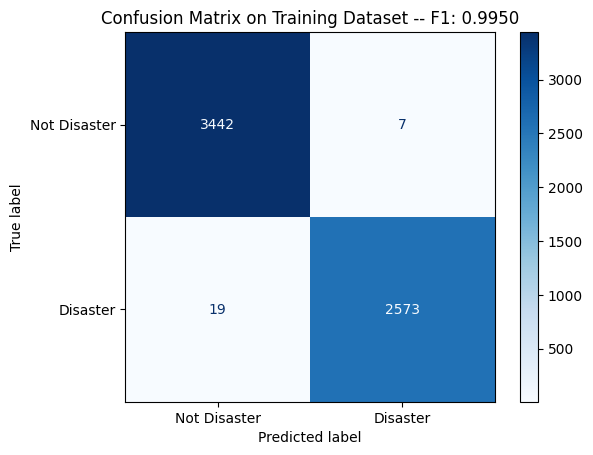

Classification report:
              precision    recall  f1-score   support

Not Disaster       0.99      1.00      1.00      3449
    Disaster       1.00      0.99      0.99      2592

    accuracy                           1.00      6041
   macro avg       1.00      1.00      1.00      6041
weighted avg       1.00      1.00      1.00      6041



In [18]:
from sklearn.metrics import f1_score

def displayConfusionMatrix(y_true, y_pred, dataset):
    y_pred = np.asarray(y_pred)

    # Convert to 1D labels:
    if y_pred.ndim == 2:
        if y_pred.shape[1] == 1:      # shape (n,1) -> squeeze
            y_pred_processed = y_pred.ravel()
        else:                         # shape (n, num_classes) -> argmax
            y_pred_processed = np.argmax(y_pred, axis=1)
    else:
        y_pred_processed = y_pred

    y_pred_processed = y_pred_processed.astype(int)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        y_pred_processed,
        display_labels=["Not Disaster", "Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_processed).ravel()
    f1 = f1_score(y_true, y_pred_processed)
    disp.ax_.set_title(f"Confusion Matrix on {dataset} Dataset -- F1: {f1:.4f}")
    plt.show()

    print("Classification report:")
    print(classification_report(y_true, y_pred_processed, target_names=["Not Disaster", "Disaster"]))

# Generate predictions for the training set
y_pred_train_proba = model.predict(X_train)
y_pred_train = (y_pred_train_proba > 0.5).astype(int)

# Call the fixed function with the predictions
displayConfusionMatrix(y_train, y_pred_train, "Training")

In [19]:
from sklearn.metrics import f1_score
import numpy as np

# Make predictions on the validation set
y_pred_proba = model.predict(X_val)

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_pred = (y_pred_proba > 0.5).astype(int)

# Calculate F1-score
f1 = f1_score(y_val, y_pred)

print(f"Model F1-score on validation set: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Model F1-score on validation set: 0.7257


In [ ]:
#Create submission.csv with predictions for the test set

# Prepare X_test from testDF (use tokenizer and same maxLen as training)
# Ensure text column has no NaNs and is string type
texts_test = testDF['text'].fillna('').astype(str)
sequences_test = tokenizer.texts_to_sequences(texts_test)
X_test = pad_sequences(sequences_test, maxlen=maxLen, padding='post')

# Use the trained model as the classifier
# If you used a different variable name for your trained model, replace `model` below accordingly.
classifier = model

# Get predictions from the trained classifier (robust to different output shapes)
probs_or_preds = classifier.predict(X_test)

if isinstance(probs_or_preds, np.ndarray):
    if probs_or_preds.ndim == 1:
        preds = (probs_or_preds > 0.5).astype(int)
    elif probs_or_preds.shape[1] == 1:
        preds = (probs_or_preds.ravel() > 0.5).astype(int)
    else:
        preds = np.argmax(probs_or_preds, axis=1)
else:
    # Fallback: try to convert to numpy array then handle
    arr = np.asarray(probs_or_preds)
    if arr.ndim == 1:
        preds = (arr > 0.5).astype(int)
    elif arr.shape[1] == 1:
        preds = (arr.ravel() > 0.5).astype(int)
    else:
        preds = np.argmax(arr, axis=1)

# Ensure length matches testDF
preds = np.asarray(preds).astype(int).reshape(-1)
if preds.shape[0] != testDF.shape[0]:
    # Align by index using testDF index
    preds = pd.Series(preds, index=testDF.index[:preds.shape[0]]).reindex(testDF.index).fillna(0).astype(int).values

submission_df = pd.DataFrame({
    "id": testDF["id"].astype(int).values,
    "target": preds
})

submission_df.to_csv("submission.csv", index=False)
print("Wrote submission.csv with", len(submission_df), "rows")
print(submission_df.head())